In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt


file_path = 'data.csv'

data = pd.read_csv(file_path)


# Vérification des informations manquantes et des doublons
missing_data = data.isnull().sum()
duplicates = data.duplicated().sum()
data = data.drop_duplicates()

# Afficher le DataFrame avec les nouvelles colonnes binaires
print(data.head())


   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


data.dropna(axis=0, inplace=True)


X = data.drop('charges', axis=1)
y = data['charges']


In [3]:
#Crée une colone de smoker en fonction du BMI
X['smoker_binary'] = (X['smoker'] == 'yes').astype(int)

#Création des intervalles pour les catégories BMI
bins = [0, 18.5, 24.9, 29.9, 34.9, 39.9, float('inf')]  # Les limites des catégories

#Étiquettes pour les catégories BMI
labels = [
    'underweight', 'normal weight', 'overweight',
    'obesity class I', 'obesity class II', 'obesity class III'
]

#Utilisation de pd.cut pour créer de nouvelles colonnes basées sur les catégories BMI
X['BMI_category'] = pd.cut(X['bmi'], bins=bins, labels=labels, right=False)

#Utilisation de pd.get_dummies pour obtenir des colonnes binaires pour chaque catégorie
BMI_dummies = pd.get_dummies(X['BMI_category'])

#Ajout des colonnes binaires au DataFrame X
X = pd.concat([X, BMI_dummies], axis=1)

X['bmi_smoker'] = X['bmi'] * X['smoker_binary']
X = X.drop('smoker_binary', axis=1)

#Suppression de la colonne 'BMI_category' car elle n'est plus nécessaire
X = X.drop('BMI_category', axis=1)

#Affichage du DataFrame avec les nouvelles colonnes binaires pour les catégories BMI
print(X)

      age     sex     bmi  children smoker     region  underweight  \
0      19  female  27.900         0    yes  southwest            0   
1      18    male  33.770         1     no  southeast            0   
2      28    male  33.000         3     no  southeast            0   
3      33    male  22.705         0     no  northwest            0   
4      32    male  28.880         0     no  northwest            0   
...   ...     ...     ...       ...    ...        ...          ...   
1333   50    male  30.970         3     no  northwest            0   
1334   18  female  31.920         0     no  northeast            0   
1335   18  female  36.850         0     no  southeast            0   
1336   21  female  25.800         0     no  southwest            0   
1337   61  female  29.070         0    yes  northwest            0   

      normal weight  overweight  obesity class I  obesity class II  \
0                 0           1                0                 0   
1                 0

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X['smoker'])
# 80% pour train et 20% de test

print("Train set X", X_train.shape)
print("Train set Y", y_train.shape)
print("Test set X", X_test.shape)
print("Test set Y", y_test.shape)

Train set X (1136, 13)
Train set Y (1136,)
Test set X (201, 13)
Test set Y (201,)


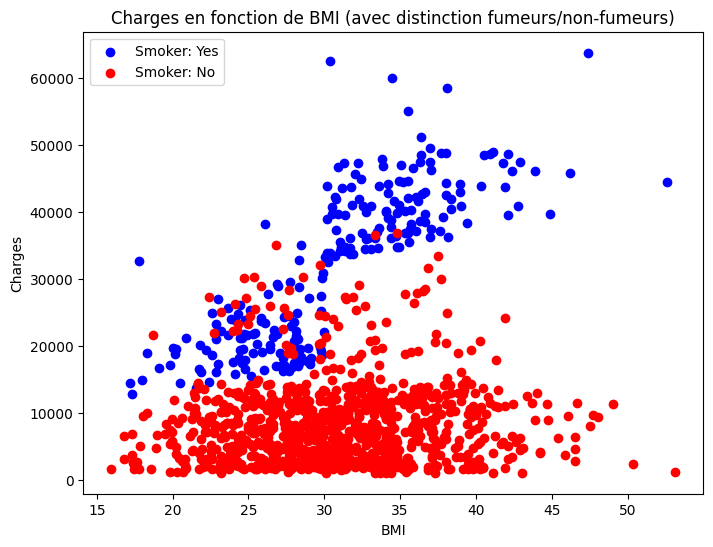

In [5]:
import matplotlib.pyplot as plt

# Création du graphique
plt.figure(figsize=(8, 6))

# Filtrage des données pour les fumeurs et non-fumeurs
smoker_yes = X_train[X_train['smoker'] == 'yes']
smoker_no = X_train[X_train['smoker'] == 'no']

# Tracé des points pour les fumeurs et non-fumeurs
plt.scatter(smoker_yes['bmi'], y_train[smoker_yes.index], color='blue', label='Smoker: Yes')
plt.scatter(smoker_no['bmi'], y_train[smoker_no.index], color='red', label='Smoker: No')

# Définition des titres et des légendes
plt.title('Charges en fonction de BMI (avec distinction fumeurs/non-fumeurs)')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.legend()

# Affichage du graphique
plt.show()


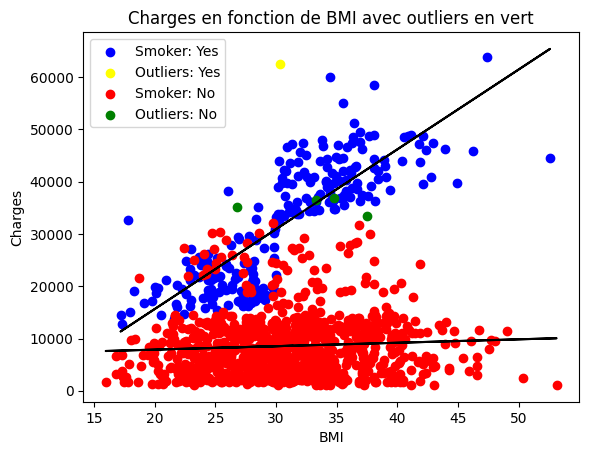

In [18]:
import numpy as np

# Filtrage des données pour les fumeurs et non-fumeurs
smoker_yes = X_train[X_train['smoker'] == 'yes']
smoker_no = X_train[X_train['smoker'] == 'no']

# Régression linéaire pour les fumeurs
regression_yes = LinearRegression()
regression_yes.fit(smoker_yes[['bmi']], y_train.loc[smoker_yes.index])
predicted_yes = regression_yes.predict(smoker_yes[['bmi']])
residuals_yes = y_train.loc[smoker_yes.index] - predicted_yes

# Identifier les points éloignés pour les fumeurs
threshold = 24000  # Seuil pour identifier les points éloignés
outliers_yes = np.abs(residuals_yes) > threshold

# Régression linéaire pour les non-fumeurs
regression_no = LinearRegression()
regression_no.fit(smoker_no[['bmi']], y_train.loc[smoker_no.index])
predicted_no = regression_no.predict(smoker_no[['bmi']])
residuals_no = y_train.loc[smoker_no.index] - predicted_no

# Identifier les points éloignés pour les non-fumeurs
outliers_no = np.abs(residuals_no) > threshold

# Tracé des points pour les fumeurs et non-fumeurs avec les points éloignés en vert
plt.scatter(smoker_yes['bmi'][~outliers_yes], y_train[smoker_yes.index][~outliers_yes], color='blue', label='Smoker: Yes')
plt.scatter(smoker_yes['bmi'][outliers_yes], y_train[smoker_yes.index][outliers_yes], color='yellow', label='Outliers: Yes')

plt.scatter(smoker_no['bmi'][~outliers_no], y_train[smoker_no.index][~outliers_no], color='red', label='Smoker: No')
plt.scatter(smoker_no['bmi'][outliers_no], y_train[smoker_no.index][outliers_no], color='green', label='Outliers: No')

# Régression linéaire pour les fumeurs et non-fumeurs
plt.plot(smoker_yes['bmi'], regression_yes.predict(smoker_yes[['bmi']]), color='black')
plt.plot(smoker_no['bmi'], regression_no.predict(smoker_no[['bmi']]), color='black')

# Définition des titres et des légendes
plt.title('Charges en fonction de BMI avec outliers en vert')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.legend()

# Affichage du graphique
plt.show()


In [17]:
# suppresion des données abérantes 

import numpy as np

# Calcul des résidus pour les fumeurs et non-fumeurs
residuals_yes = y_train.loc[smoker_yes.index] - predicted_yes
residuals_no = y_train.loc[smoker_no.index] - predicted_no

# Identifier les indices des points éloignés pour les fumeurs et non-fumeurs
outliers_yes = np.abs(residuals_yes) > threshold
outliers_no = np.abs(residuals_no) > threshold

# Supprimer les points éloignés de la base de données pour les fumeurs
smoker_yes_cleaned = smoker_yes[~outliers_yes]

# Supprimer les points éloignés de la base de données pour les non-fumeurs
smoker_no_cleaned = smoker_no[~outliers_no]

# Nouvelle base de données sans les points éloignés
X_cleaned = pd.concat([smoker_yes_cleaned, smoker_no_cleaned])

# Vérification des dimensions avant et après nettoyage
print(f"Dimensions de la base de données avant nettoyage : {X_train.shape}")
print(f"Dimensions de la base de données après nettoyage : {X_cleaned.shape}")
# Filtrage des données aberrantes pour y_train en fonction des mêmes points que X_train
y_train_cleaned = y_train.drop(index=outliers_yes[outliers_yes].index)
y_train_cleaned = y_train_cleaned.drop(index=outliers_no[outliers_no].index)


# Vérification des dimensions de y_train avant et après nettoyage
print(f"Dimensions de y_train avant nettoyage : {y_train.shape}")
print(f"Dimensions de y_train après nettoyage : {y_train_cleaned.shape}")

# Assigner les données nettoyées à X_train et y_train
# X_train = X_cleaned
# y_train = y_train_cleaned

Dimensions de la base de données avant nettoyage : (1136, 13)
Dimensions de la base de données après nettoyage : (1131, 13)
Dimensions de y_train avant nettoyage : (1136,)
Dimensions de y_train après nettoyage : (1131,)


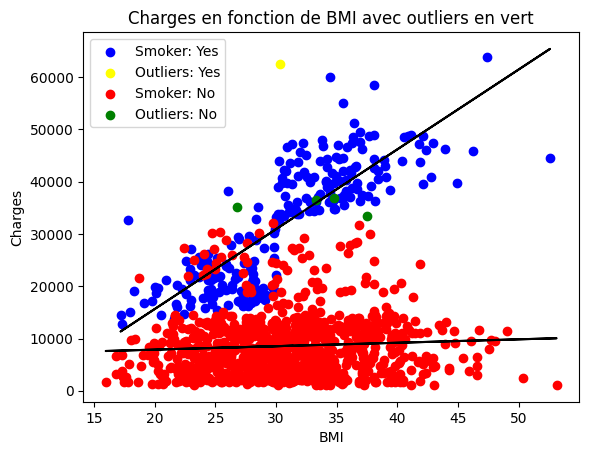

In [8]:
import numpy as np

# Filtrage des données pour les fumeurs et non-fumeurs
smoker_yes = X_train[X_train['smoker'] == 'yes']
smoker_no = X_train[X_train['smoker'] == 'no']

# Régression linéaire pour les fumeurs
regression_yes = LinearRegression()
regression_yes.fit(smoker_yes[['bmi']], y_train.loc[smoker_yes.index])
predicted_yes = regression_yes.predict(smoker_yes[['bmi']])
residuals_yes = y_train.loc[smoker_yes.index] - predicted_yes

# Identifier les points éloignés pour les fumeurs
threshold = 24000  # Seuil pour identifier les points éloignés
outliers_yes = np.abs(residuals_yes) > threshold

# Régression linéaire pour les non-fumeurs
regression_no = LinearRegression()
regression_no.fit(smoker_no[['bmi']], y_train.loc[smoker_no.index])
predicted_no = regression_no.predict(smoker_no[['bmi']])
residuals_no = y_train.loc[smoker_no.index] - predicted_no

# Identifier les points éloignés pour les non-fumeurs
outliers_no = np.abs(residuals_no) > threshold

# Tracé des points pour les fumeurs et non-fumeurs avec les points éloignés en vert
plt.scatter(smoker_yes['bmi'][~outliers_yes], y_train[smoker_yes.index][~outliers_yes], color='blue', label='Smoker: Yes')
plt.scatter(smoker_yes['bmi'][outliers_yes], y_train[smoker_yes.index][outliers_yes], color='yellow', label='Outliers: Yes')

plt.scatter(smoker_no['bmi'][~outliers_no], y_train[smoker_no.index][~outliers_no], color='red', label='Smoker: No')
plt.scatter(smoker_no['bmi'][outliers_no], y_train[smoker_no.index][outliers_no], color='green', label='Outliers: No')

# Régression linéaire pour les fumeurs et non-fumeurs
plt.plot(smoker_yes['bmi'], regression_yes.predict(smoker_yes[['bmi']]), color='black')
plt.plot(smoker_no['bmi'], regression_no.predict(smoker_no[['bmi']]), color='black')

# Définition des titres et des légendes
plt.title('Charges en fonction de BMI avec outliers en vert')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.legend()

# Affichage du graphique
plt.show()


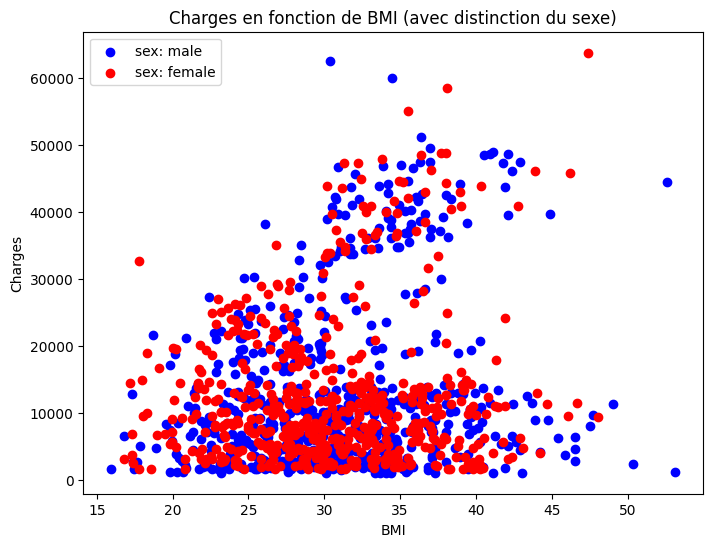

In [9]:
import matplotlib.pyplot as plt

# Création du graphique
plt.figure(figsize=(8, 6))

# Filtrage des données pour les fumeurs et non-fumeurs
male = X_train[X_train['sex'] == 'male']
female = X_train[X_train['sex'] == 'female']

# Tracé des points pour les fumeurs et non-fumeurs
plt.scatter(male['bmi'], y_train[male.index], color='blue', label='sex: male')
plt.scatter(female['bmi'], y_train[female.index], color='red', label='sex: female')

# Définition des titres et des légendes
plt.title('Charges en fonction de BMI (avec distinction du sexe)')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.legend()

# Affichage du graphique
plt.show()


In [10]:

# Identifier les colonnes catégories et numériques
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns


# Créer le pipeline pour les features numériques
numerical_pipeline = Pipeline([
    ('poly', PolynomialFeatures(2)),
    ('scaler', StandardScaler()) # Ajout de PolynomialFeatures
])


# Créer le pipeline pour les features catégorielles
categorial_pipeline = Pipeline([
    ('encoder', OneHotEncoder()),
    ('poly', PolynomialFeatures(2))
])


# Combine les pipelines en utilisant ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_pipeline, numerical_cols),
        ('categorial', categorial_pipeline, categorical_cols)
    ])




# Créer le pipeline final en ajoutant le model

LR_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regression', LinearRegression())
])

Lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('Lasso', Lasso())
])

ElasticNet_pipeline = Pipeline([
    ('prepocessor', preprocessor),
    ('ElasticNet', ElasticNet())
])

print (len(X_train))
print (len(y_train))

# On entraine les donnnées
LR_pipeline.fit(X_train, y_train)
Lasso_pipeline.fit(X_train, y_train)
ElasticNet_pipeline.fit(X_train, y_train)






1136
1136


/Users/cyriljulliard/simplon/AssurePeopleUsa/env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.393e+09, tolerance: 1.667e+07
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Pipeline(steps=[('prepocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'bmi', 'children', 'bmi_smoker'], dtype='object')),
                                                 ('categorial',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder()),
                                                                  ('poly',
                                                                   PolynomialFeatures())]),
                                                  Index(['sex', '

In [11]:
# On predicte Linear Regression
y_pred_LR = LR_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred_LR)
r2 = r2_score(y_test, y_pred_LR)
rmse = np.sqrt(mse)
print(f" score du LR modèle : {LR_pipeline.score(X_test, y_test)}")
print(f"mse : {mse}")
print(f"r2 : {r2}")
print(f"rmse : {rmse}")

 score du LR modèle : 0.9012578054089125
mse : 14309303.002365045
r2 : 0.9012578054089125
rmse : 3782.763936907119


In [12]:
# On predicte Lasso
y_pred_Lasso = Lasso_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred_Lasso)
r2 = r2_score(y_test, y_pred_Lasso)
rmse = np.sqrt(mse)
print(f" score du Lasso modèle : {Lasso_pipeline.score(X_test, y_test)}")
print(f"mse : {mse}")
print(f"r2 : {r2}")
print(f"rmse : {rmse}")

 score du Lasso modèle : 0.9003179227707967
mse : 14445506.836107634
r2 : 0.9003179227707967
rmse : 3800.7245146297614


In [13]:
# On predicte ElasticNet
y_pred_EN = ElasticNet_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred_EN)
r2 = r2_score(y_test, y_pred_EN)
rmse = np.sqrt(mse)
print(f" score du ELASTICNET modèle : {ElasticNet_pipeline.score(X_test, y_test)}")
print(f"mse : {mse}")
print(f"r2 : {r2}")
print(f"rmse : {rmse}")


 score du ELASTICNET modèle : 0.8888520342069
mse : 16107095.119936995
r2 : 0.8888520342069
rmse : 4013.364563547273


In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = { 
    'ElasticNet__alpha': np.arange(0.1, 0.2, 0.1),
    'ElasticNet__l1_ratio': np.arange(0.80, 0.96, 0.01)
}

grid = GridSearchCV(ElasticNet_pipeline, param_grid, cv= 5)

grid.fit(X_train, y_train)
print(grid.best_params_)

model = grid.best_estimator_

model.score(X_test, y_test)

{'ElasticNet__alpha': 0.1, 'ElasticNet__l1_ratio': 0.9500000000000002}


/Users/cyriljulliard/simplon/AssurePeopleUsa/env/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.326e+07, tolerance: 1.271e+07
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


0.8979453113358633

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'underweight',
       'normal weight', 'overweight', 'obesity class I', 'obesity class II',
       'obesity class III', 'bmi_smoker'],
      dtype='object')
Index(['age', 'bmi', 'children', 'underweight', 'normal weight', 'overweight',
       'obesity class I', 'obesity class II', 'obesity class III',
       'bmi_smoker', 'sex_female', 'sex_male', 'smoker_no', 'smoker_yes',
       'region_northeast', 'region_northwest', 'region_southeast',
       'region_southwest', 'sex_group'],
      dtype='object')


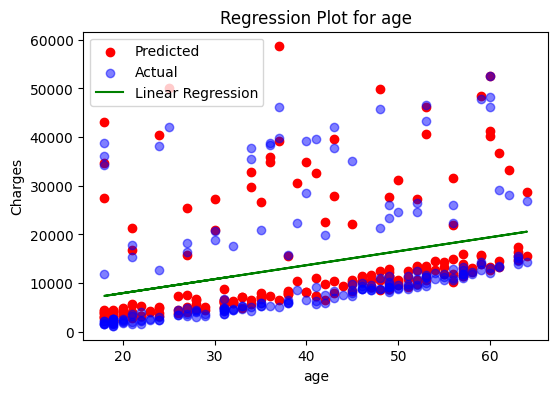

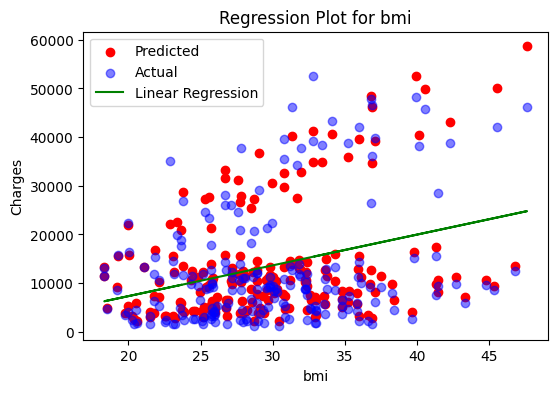

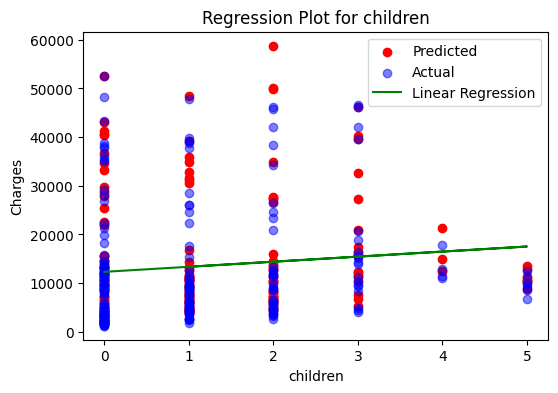

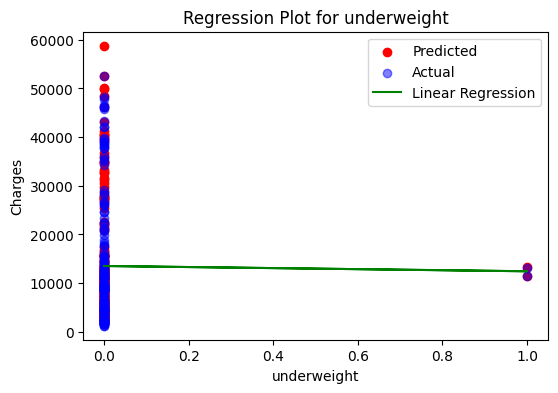

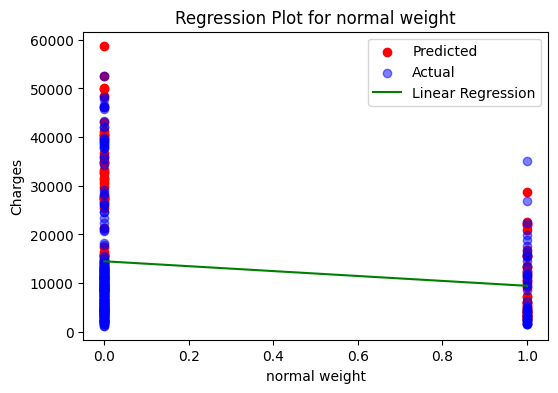

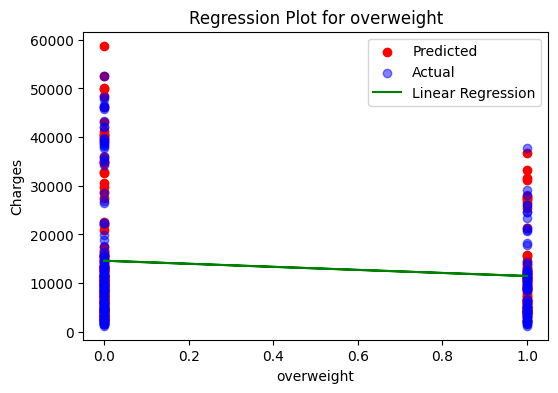

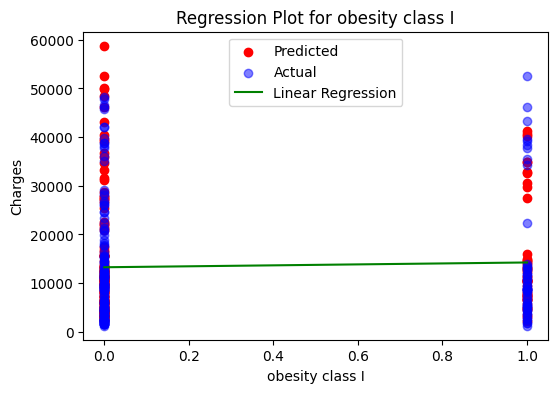

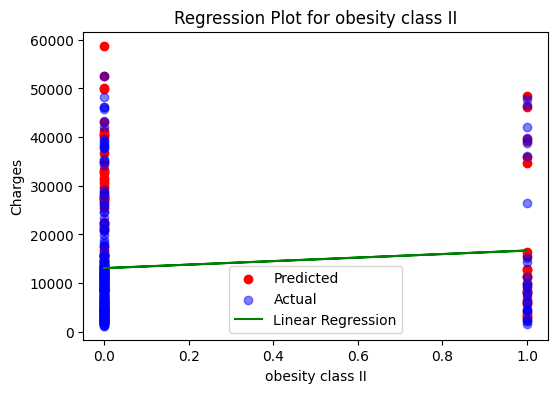

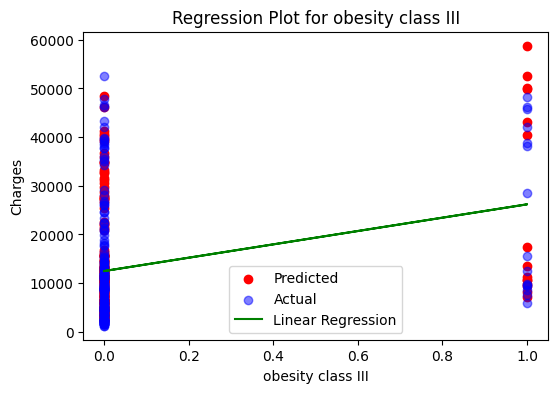

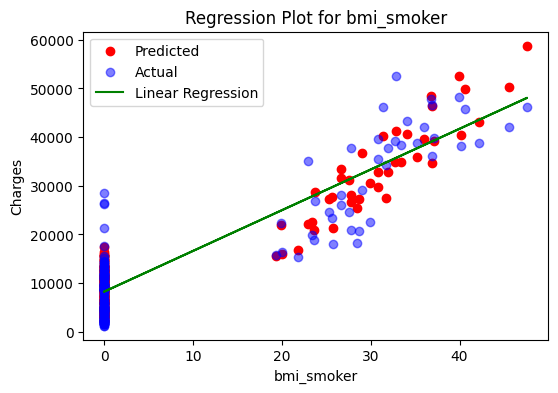

KeyError: "None of [Index(['sex_female'], dtype='object')] are in the [columns]"

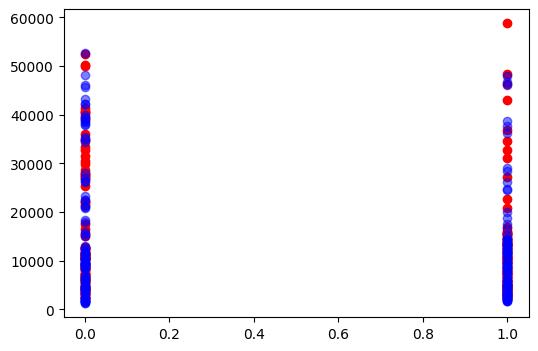

In [15]:
from sklearn.linear_model import LinearRegression

# Créer une régression linéaire
regression = LinearRegression()
y_pred = grid.predict(X_test)
X_test_encoded = X_test
print(X_test_encoded.columns)

X_test_encoded = pd.get_dummies(X_test, columns=['sex', 'smoker', 'region'])
X_test_encoded['sex_group'] = X_test_encoded['sex_female'] + X_test_encoded['sex_male']

print(X_test_encoded.columns)
# Parcourir chaque colonne de X
for col in X_test_encoded.columns:
    # Créer une figure et un axe pour chaque colonne
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Fit de la régression linéaire sur la colonne actuelle et les valeurs prédites
    regression.fit(X_test_encoded[[col]], y_pred)
    
    # Tracer les valeurs prédites en fonction de la colonne actuelle
    ax.scatter(X_test_encoded[col], y_pred, color='red', label='Predicted')
    
    # Tracer les valeurs réelles en fonction de la colonne actuelle
    ax.scatter(X_test_encoded[col], y_test, color='blue', alpha=0.5, label='Actual')
    
    # Tracer la ligne de régression linéaire pour la colonne actuelle
    ax.plot(X_test_encoded[col], regression.predict(X_test[[col]]), color='green', label='Linear Regression')
    
    # Ajouter des étiquettes et une légende pour la colonne actuelle
    ax.set_xlabel(col)
    ax.set_ylabel('Charges')
    ax.legend()
    
    # Afficher le titre basé sur la colonne
    ax.set_title(f'Regression Plot for {col}')
    
    # Afficher le graphique pour la colonne actuelle
    plt.show()


In [ ]:
# test sur une personne lambda:
X_Subject = pd.DataFrame({
    'age': [28],
    'sex': [0],
    'bmi': [26],
    'children': [0],
    'smoker': [0],
    'is_northeast': [1],
    'is_northwest': [0],
    'is_southeast': [0],
    'is_southwest': [0]
})

y_subject = grid.predict(X_Subject)
print("Avec mes données, je payerai:", y_subject)

Avec mes données, je payerai: [ 5131.83243099 28381.8882462   8850.04197243 31598.26904903
 26090.16118865  9335.75944031  3614.95152304  6811.76058092
  3333.45932605 29051.12949994 11558.44409618 14286.70296261
  2228.14591241 17898.18280299  2663.75243042   945.19556153
  4503.27519465  6264.22959388  4066.97713472 26290.12848025
 13887.01489971 10220.72820971 11447.57595771 15321.56601825
  8159.63715031  5703.15850613 11297.96494631 12189.59746369
  2902.52120939  6019.01428904  5353.03376205 13073.87194096
 10602.36985573 24414.65313581 25392.97856682 33458.57232953
  4735.17973061 12942.18194924 20649.6966051   8158.14029351
  7374.44965649  6829.73690279 30109.0030752  22145.70989027
 31667.80343839  4673.42567979 14282.78146021 11677.51313913
 25770.68449934 11886.34148837  8102.95481605 33636.61469309
 16677.10492859 14746.13822965  5673.22209191 17579.35965195
  8849.81213709  9310.79021129 10229.00473766  5502.40583924
  2663.90499706 32256.23729961 12720.31842587 10937.195

0.8246944526310988